In [ ]:
!pip install albumentations
!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

  Cloning https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to /tmp/pip-req-build-rcf5bege
  Running command git clone --filter=blob:none --quiet https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup /tmp/pip-req-build-rcf5bege
  Resolved https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to commit 12d03c07553aedd3d9e9155e2b3e31ce8c64081a
  Preparing metadata (setup.py) ... done
  Created wheel for cosine-annealing-warmup: filename=cosine_annealing_warmup-2.0-py3-none-any.whl size=4168 sha256=47343061b294fd6219954f00c2ee24d39d7a754657b4fec354f806a6eadb5d2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-q8fw_1ds/wheels/29/26/10/bf1a07417dd54aa73bdf09ce4f31c187974a444a1cedddbd99
Successfully built cosine-annealing-warmup


In [ ]:
# Library
import pandas as pd
import numpy as np
import os
import torch.optim as optim
from torch.nn import functional as F
import sys
import random
import csv
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
from sklearn.metrics import accuracy_score

In [ ]:
# Configures
cfg={}
cfg['batch_size'] = 8
cfg['lr'] = 1e-4
cfg['min_lr'] = 1e-7
cfg['image_size'] = 256
cfg['datasplit'] = 0.8
cfg['epoch'] = 6
cfg['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg['seed'] = 20230712
cfg['T0'] = 4

In [ ]:
# Seed
seed = cfg['seed']

def setSeed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    pd.core.common.random_state(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

setSeed(seed)

In [ ]:
# Load data
from google.colab import drive
drive.mount('/content/drive')

base_path = "./drive/My Drive/Colab Notebooks/shopee-product-matching"
train_image_path = os.path.join(base_path,'train_images')
test_image_path = os.path.join(base_path,'test_images')

sample_sub = os.path.join(base_path,'sample_submission.csv')

Mounted at /content/drive


In [ ]:
all_data_df = pd.read_csv(os.path.join(base_path,'train.csv'))
all_data_df.head(10)

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069
5,train_2464356923,0013e7355ffc5ff8fb1ccad3e42d92fe.jpg,bbd097a7870f4a50,CELANA WANITA (BB 45-84 KG)Harem wanita (bisa...,2660605217
6,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137
7,train_1806152124,0014f61389cbaa687a58e38a97b6383d.jpg,eea7e1c0c04da33d,KULOT PLISKET SALUR /CANDY PLISKET /WISH KULOT...,1565741687
8,train_86570404,0019a3c6755a194cb2e2c12bfc63972e.jpg,ea9af4f483249972,"[LOGU] Tempelan kulkas magnet angka, tempelan ...",2359912463
9,train_831680791,001be52b2beec40ddc1d2d7fc7a68f08.jpg,e1ce953d1a70618f,BIG SALE SEPATU PANTOFEL KULIT KEREN KERJA KAN...,2630990665


In [ ]:
# Image Augumentation
import albumentations
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip,
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout,
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue,
    )
from albumentations.pytorch import ToTensorV2

def get_train_transforms(Config):
    return albumentations.Compose([
        albumentations.RandomCrop(cfg['image_size'], cfg['image_size']),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(0.5),
        albumentations.Transpose(p=0.5),
        albumentations.Rotate(limit=(-90, 90), p=0.5),
        albumentations.OneOf([
           albumentations.ShiftScaleRotate(),
           albumentations.ElasticTransform(alpha=3)
        ], p=0.5),
        albumentations.OneOf([
           albumentations.OpticalDistortion(distort_limit=1.0),
           albumentations.GridDistortion(num_steps=5, distort_limit=1.0)
        ], p=0.5),
        albumentations.Cutout(max_h_size=int(cfg['image_size'] * 0.375), max_w_size=int(cfg['image_size'] * 0.375), num_holes=1, p=0.5),
        albumentations.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225], max_pixel_value=255, p=1.0),
        ToTensorV2(p=1.0)
    ])
def get_test_transforms(Config):
    return albumentations.Compose([
        albumentations.CenterCrop(p=1.0, height = cfg['image_size'], width = cfg['image_size']),
        albumentations.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225], max_pixel_value=255, p=1.0),
        ToTensorV2(p=1.0)
    ])

In [ ]:
# Dataset for Siamese Model
class SiameseDataset(Dataset):
    def __init__(self,image_1,image_2,labels,dim=(cfg['image_size'],cfg['image_size']),augmentation=None):
        self.image_1 = image_1
        self.image_2 = image_2
        self.labels = labels
        self.dim = dim
        self.augmentation = augmentation

    def __len__(self):
        return len(self.image_1)

    def __getitem__(self,index):
        img_0 = self.image_1[index]
        img_1 = self.image_2[index]

        img_0 = cv2.imread(f'{train_image_path}/{img_0}')
        img_1 = cv2.imread(f'{train_image_path}/{img_1}')

        img_0 = cv2.cvtColor(img_0, cv2.COLOR_BGR2RGB)
        img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)

        if self.dim:
            img_0 = cv2.resize(img_0,self.dim)
            img_1 = cv2.resize(img_1,self.dim)

        if self.augmentation:
            augmented_0 = self.augmentation(image=img_0)
            augmented_1 = self.augmentation(image=img_1)
            img_0 = augmented_0['image']
            img_1 = augmented_1['image']


        return img_0,img_1 ,torch.tensor(self.labels[index],dtype=torch.float32)

In [ ]:
# Siamese Model
class SiameseModel(nn.Module):
    def __init__(self,out_features=2,pretrained=True):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),

            nn.MaxPool2d(kernel_size=3),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=.2),

            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Dropout2d(p=.2),

            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Dropout2d(p=.2),

            nn.MaxPool2d(kernel_size=3),

            nn.Conv2d(256, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=.2),

            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=.2),

            nn.Conv2d(128, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),

            nn.MaxPool2d(kernel_size=3),

            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.2),
        )
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(64,2),
            nn.ReLU(),
            nn.Linear(2, out_features)
        )

    def forward_once(self, x):
        bs = x.size(0)
        output = self.model(x)
        output = self.pooling(output).view(bs, -1)

        return output
    def forward(self, image_1,image_2):
        output_1 = self.forward_once(image_1)
        output_2 = self.forward_once(image_2)

        output = torch.cat((output_1, output_2),1)
        output = self.classifier(output)

        return output


In [ ]:
# Siamese Data
data = pd.read_csv(os.path.join(base_path,'train.csv'))
data_without_dup = data.drop_duplicates(subset='label_group')

In [ ]:
posting_id_dict = data.groupby('label_group')['posting_id'].unique().to_dict()
title_dict = data.groupby('label_group')['title'].unique().to_dict()
image_dict = data.groupby('label_group')['image'].unique().to_dict()

In [ ]:
label_groups = data_without_dup.label_group.values.tolist()

In [ ]:
new_data = []
for i,label_group in tqdm(enumerate(data_without_dup['label_group'])):
    matches = posting_id_dict[label_group].tolist()
    titles = title_dict[label_group].tolist()
    images = image_dict[label_group].tolist()

    index = np.random.randint(2,len(label_groups)-2)
    while (index== i):
        index = np.random.randint(0,len(label_groups))

    if len(matches) == 2:
        if len(titles) == 2:
            matches.extend(titles)
            matches.extend(images)
            matches.extend([1])
        else:
            matches.extend([titles[0],titles[0]])
            matches.extend(images)
            matches.extend([1])
        new_data.append(matches)
        new_data.append([matches[0],posting_id_dict[label_groups[index]][0],titles[0],title_dict[label_groups[index]][0],images[0],image_dict[label_groups[index]][0],0])
        new_data.append([matches[0],posting_id_dict[label_groups[index+1]][0],titles[0],title_dict[label_groups[index+1]][0],images[0],image_dict[label_groups[index+1]][0],0])
        new_data.append([matches[0],posting_id_dict[label_groups[index-1]][0],titles[0],title_dict[label_groups[index-1]][0],images[0],image_dict[label_groups[index-1]][0],0])

    else:
        for match,title,image in zip(matches[1:],titles[1:],images[1:]):
            new_data.append([matches[0],match,titles[0],title,images[0],image,1])
            new_data.append([matches[0],posting_id_dict[label_groups[index]][0],titles[0],title_dict[label_groups[index]][0],images[0],image_dict[label_groups[index]][0],0])

11014it [00:00, 37148.27it/s]


In [ ]:
siamese_data = pd.DataFrame(new_data,columns=['posting_id_1','posting_id_2','title_1','title_2','image_1','image_2','label'])

In [ ]:
siamese_data

,posting_id_1,posting_id_2,title_1,title_2,image_1,image_2,label
0,train_129225211,train_2278313361,Paper Bag Victoria Secret,PAPER BAG VICTORIA SECRET,0000a68812bc7e98c42888dfb1c07da0.jpg,f83b49a86a0ee8592e3bf0204da3fbdf.jpg,1
1,train_129225211,train_3717368125,Paper Bag Victoria Secret,Celana dalam anak / Celana dalam anak laki lak...,0000a68812bc7e98c42888dfb1c07da0.jpg,08f64ae0676409b7ad5435ea92fb2c5e.jpg,0
2,train_129225211,train_247048247,Paper Bag Victoria Secret,MW / GAMIS SET SYARI / FIRDAUS SYARI XXL,0000a68812bc7e98c42888dfb1c07da0.jpg,08f7c8506c6ad1ff57d9249b50621f80.jpg,0
3,train_129225211,train_1595076746,Paper Bag Victoria Secret,Hanasui Body Spa Lemon With Collagen 300ml,0000a68812bc7e98c42888dfb1c07da0.jpg,08f268f4793868c9a2280c404e504460.jpg,0
4,train_3386243561,train_3423213080,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",Double Tape VHB 3M ORIGINAL 12mm x 4.5mm Busa ...,00039780dfc94d01db8676fe789ecd05.jpg,8cbe4bf9706bc177fd61071ef776be8c.jpg,1
...,...,...,...,...,...,...,...
55701,train_2244662893,train_1478137076,LAMPU HURUF A-Z DAN ANGKA 0-9 \xe2\x9d\xa4\xef...,Denpoo DEP-858VT Electro Pot / Termos Listrik ...,fd68da190e8739150321d72eeab52c0d.jpg,94fcbac70cd5d4e17ce667d843181344.jpg,0
55702,train_4221982820,train_4063409014,Sprei Lady Rose 180x200 King terlaris Keroppi,Sprei king ladyrose size 180x200 kerokeroppi,ff512b2f4ff8bb431bf089e87c212922.jpg,ff7180bf7d0cf29f0b173952e6cf7af2.jpg,1
55703,train_4221982820,train_2275982538,Sprei Lady Rose 180x200 King terlaris Keroppi,Mika Lampu Stop Nmax NEMO/ Kaca Mika StopLamp ...,ff512b2f4ff8bb431bf089e87c212922.jpg,1c163f465acc7e3e74a6af0b0be1b45d.jpg,0
55704,train_4221982820,train_349402318,Sprei Lady Rose 180x200 King terlaris Keroppi,Live sale 5-35 rb,ff512b2f4ff8bb431bf089e87c212922.jpg,1c17a310fcf5750e557bbc46d33dd87c.jpg,0


In [ ]:
# Prepare training data
train_label_df = siamese_data

In [ ]:
def splitDataset(df,p=0.8):
    df=df.sample(frac=1,random_state=seed).reset_index(drop=True)
    train_df = df.iloc[:int(len(df)*p)]
    valid_df = df.iloc[int(len(df)*p):]
    return train_df , valid_df

In [ ]:
train_df , valid_df = splitDataset(train_label_df,cfg['datasplit'])

In [ ]:
train_dataset = SiameseDataset(image_1 = train_df['image_1'].values.tolist(),image_2 = train_df['image_2'].values.tolist(),labels = train_df['label'].values.tolist(),dim = (cfg['image_size'],cfg['image_size']),augmentation=get_train_transforms(cfg),)
valid_dataset = SiameseDataset(image_1 = valid_df['image_1'].values.tolist(),image_2 = valid_df['image_2'].values.tolist(),labels = valid_df['label'].values.tolist(),dim = (cfg['image_size'],cfg['image_size']),augmentation=get_test_transforms(cfg),)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=cfg['batch_size'],pin_memory=True,drop_last=False,num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=cfg['batch_size'],pin_memory=True,drop_last=False,num_workers=4)

In [ ]:
# Prepare Model

In [ ]:
model = SiameseModel().to(cfg['device'])

In [ ]:
certification = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg['lr'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=cfg['T0'], T_mult=1, eta_min=cfg['min_lr'], last_epoch=-1)

In [ ]:
def train_epoch(model, dataloader, certification, optimizer):
    model.train()
    totalloss=0
    totalacc=0
    with tqdm(dataloader,unit='batch',desc='Train') as tqdm_loader:
        for idx,(image_1, image_2,label) in enumerate(tqdm_loader):
            image_1 = image_1.to(device=cfg['device'])
            image_2 = image_2.to(device=cfg['device'])
            label = label.to(device=cfg['device'])
            label = torch.tensor(label, dtype=torch.long)

            pred = model(image_1,image_2)
            loss = certification(pred,label)
            pred = pred.cpu().detach().argmax(dim=1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            nowloss = loss.detach().item()
            totalloss +=nowloss
            acc = accuracy_score(pred,label.cpu())
            totalacc +=acc

            tqdm_loader.set_postfix(loss=nowloss,avgloss=totalloss/(idx+1),avgACC=totalacc/(idx+1) )

@torch.no_grad()
def eval_epoch(model, dataloader, certification):
    model.eval()
    totalloss = 0
    bestloss = 10
    totalacc = 0
    bestacc = 0
    with torch.no_grad():
        with tqdm(dataloader,unit='batch',desc='Valid') as tqdm_loader:
            for idx,(image_1, image_2,label) in enumerate(tqdm_loader):
                image_1 = image_1.to(device=cfg['device'])
                image_2 = image_2.to(device=cfg['device'])
                label = label.to(device=cfg['device'])
                label = torch.tensor(label, dtype=torch.long)

                pred = model(image_1,image_2)
                loss = certification(pred,label)
                pred = pred.cpu().detach().argmax(dim=1)

                nowloss = loss.detach().item()
                totalloss +=nowloss
                acc = accuracy_score(pred,label.cpu())
                totalacc +=acc

                tqdm_loader.set_postfix(loss=nowloss,avgloss=totalloss/(idx+1),avgACC=totalacc/(idx+1) )
            avgloss = totalloss/len(tqdm_loader)
            avgacc = totalacc/len(tqdm_loader)
            if avgacc > bestacc:
                bestacc = avgacc
                bestloss = avgloss
                torch.save(model.state_dict(),'best_model.pkl')
                torch.save(model.state_dict(),'best_model.pkl')
            elif avgacc == bestacc:
                if avgloss <= bestloss:
                    bestloss = avgloss
                    torch.save(model.state_dict(),'best_model.pkl')
                    torch.save(model.state_dict(),'best_model.pkl')

In [ ]:
# training
for epoch in range(cfg['epoch']):
    print('\nEpoch {}'.format(epoch))
    train_epoch(model,train_loader,certification,optimizer)
    eval_epoch(model,valid_loader,certification)
    scheduler.step()


Epoch 0


Valid: 100%|██████████| 1393/1393 [07:25<00:00,  3.12batch/s, avgACC=0.548, avgloss=0.652, loss=0.754]



Epoch 1


Valid: 100%|██████████| 1393/1393 [01:16<00:00, 18.23batch/s, avgACC=0.633, avgloss=0.638, loss=0.708]



Epoch 2


Valid: 100%|██████████| 1393/1393 [01:16<00:00, 18.17batch/s, avgACC=0.642, avgloss=0.631, loss=0.748]



Epoch 3


Valid: 100%|██████████| 1393/1393 [01:16<00:00, 18.27batch/s, avgACC=0.644, avgloss=0.628, loss=0.752]



Epoch 4


Valid: 100%|██████████| 1393/1393 [01:16<00:00, 18.17batch/s, avgACC=0.66, avgloss=0.624, loss=0.775]



Epoch 5


Valid: 100%|██████████| 1393/1393 [01:16<00:00, 18.22batch/s, avgACC=0.67, avgloss=0.614, loss=0.623]


In [ ]:
# Configures
cfg={}
cfg['batch_size'] = 8
cfg['lr'] = 1e-4
cfg['min_lr'] = 1e-7
cfg['image_size'] = 256
cfg['datasplit'] = 0.8
cfg['epoch'] = 10
cfg['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg['seed'] = 20230712
cfg['T0'] = 4

In [ ]:
# training
for epoch in range(cfg['epoch']):
    print('\nEpoch {}'.format(epoch))
    train_epoch(model,train_loader,certification,optimizer)
    eval_epoch(model,valid_loader,certification)
    scheduler.step()


Epoch 0


Valid: 100%|██████████| 1393/1393 [01:12<00:00, 19.09batch/s, avgACC=0.686, avgloss=0.597, loss=0.605]



Epoch 1


Valid: 100%|██████████| 1393/1393 [01:13<00:00, 18.98batch/s, avgACC=0.684, avgloss=0.598, loss=0.595]



Epoch 2


Valid: 100%|██████████| 1393/1393 [01:13<00:00, 18.98batch/s, avgACC=0.685, avgloss=0.596, loss=0.578]



Epoch 3


Valid: 100%|██████████| 1393/1393 [01:13<00:00, 19.05batch/s, avgACC=0.686, avgloss=0.595, loss=0.559]



Epoch 4


Valid: 100%|██████████| 1393/1393 [01:12<00:00, 19.09batch/s, avgACC=0.683, avgloss=0.596, loss=0.597]



Epoch 5


Valid: 100%|██████████| 1393/1393 [01:13<00:00, 19.07batch/s, avgACC=0.686, avgloss=0.595, loss=0.568]



Epoch 6


Valid: 100%|██████████| 1393/1393 [01:12<00:00, 19.09batch/s, avgACC=0.688, avgloss=0.594, loss=0.589]



Epoch 7


Valid: 100%|██████████| 1393/1393 [01:12<00:00, 19.12batch/s, avgACC=0.687, avgloss=0.595, loss=0.588]



Epoch 8


Valid: 100%|██████████| 1393/1393 [01:13<00:00, 19.07batch/s, avgACC=0.688, avgloss=0.592, loss=0.556]



Epoch 9


Valid: 100%|██████████| 1393/1393 [01:12<00:00, 19.12batch/s, avgACC=0.689, avgloss=0.592, loss=0.619]


In [ ]:
epoch_range = [i for i in range(10)]
avgACC_train = [0.654, 0.653, 0.653, 0.656, 0.656, 0.657, 0.655, 0.657, 0.655, 0.658]
avgACC_valid = [0.686, 0.684, 0.685, 0.686, 0.683, 0.686, 0.688, 0.687, 0.688, 0.689]
avgloss_train = [0.63, 0.629, 0.627, 0.626, 0.627, 0.627, 0.627, 0.625, 0.626, 0.627]
avgloss_valid = [0.597, 0.598, 0.596, 0.595, 0.596, 0.595, 0.594, 0.595, 0.592, 0.592]

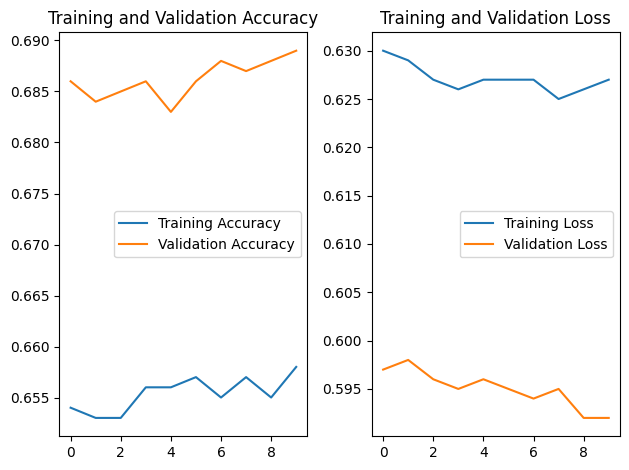

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(epoch_range, avgACC_train, label='Training Accuracy')
plt.plot(epoch_range, avgACC_valid, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epoch_range, avgloss_train, label='Training Loss')
plt.plot(epoch_range, avgloss_valid, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()